# Golf Training Session Analysis

As a mid-handicap golfer, I can improve in virtually every aspect of my game. That is why I have decided to undergo this project. The aim is to narrow down the areas that I need to work on, to catch up to other aspects of my golf game that I already excel at. I will also use this to verify how far I hit each of my clubs, and make sure that there aren't any large gaps that I need to fill. Each club should go about 10 yards further than the last. (ie. if I hit my 8 iron 140 yards, I want to be hitting my 7 iron about 150 yards.)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d 
import numpy as np
import mplcursors as mplc
import math

from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model, metrics
import statsmodels.formula.api as smf

import glob
import os

import requests
from bs4 import BeautifulSoup
from PIL import Image

## The data

This is all real data collected using the Rapsodo MLM2Pro mobile launch monitor and an iPad app called Awesome golf. The Rapsodo device uses radar to track how fast the ball travels, the trajectory of the ball, the speed that the club is swinging, and it uses high speed cameras to calculate the spin rate and spin axis of the ball after it's hit. The data that the device collects is then sent to a 3rd party app called Awesome Golf. Awesome golf takes these numbers and estimates the flight path of the ball, giving estimates of carry distance, lateral carry distance, peak height and more.

At the end of a training session, I will download all of this data from Awesome Golf as a csv file. I will then import all of the collected csv files here into a single dataframe.

The below image shows what you can see on the iPad after every shot. The yellow tracer line is the last shot hit and all of the red tracers are previous shots. At the bottom of the screen, you can see the club head speed, ball speed, ball launch angle, spin rate, carry distance and total distance.

<img src="golf_sim.PNG" alt="drawing" width="600"/>

In [2]:
#function to read in all csv files from a specified location
def read_all_files(folder_path, file_extension='csv'):

    all_files = glob.glob(os.path.join(folder_path, f"*.{file_extension}"))
    if not all_files:
        return pd.DataFrame()

    all_df = []
    for f in all_files:
        df = pd.read_csv(f)
        all_df.append(df)

    combined_df = pd.concat(all_df, ignore_index=True)

    print(len(all_files), 'files imported from directory: ', folder_path)
    
    return combined_df

In [3]:
folder_path = 'shot_csvs'
file_extension = 'csv'

df = read_all_files(folder_path, file_extension)


4 files imported from directory:  shot_csvs


## EDA and Data Cleanup

Looking at the dataframe, we can see that there are a handful of columns that we won't need. Anything related to the swing (excluding swing speed) such as Club Path, Face Path, Swing Plane Tilt, etc. was not collected by the Rapsodo, so we can remove all of those columns. We also need to be careful, because the first row of every csv file contains the unit of measure. I will remove these rows along with any rows that contain null values in the columns that I will be using.


In [4]:
df.head()

,Date,Club Type,Club Description,Altitude,Club Speed,Ball Speed,Carry Distance,Total Distance,Roll Distance,Smash,...,Spin Rate,Spin Axis,Spin Reading,Low Point,Club Path,Face Path,Face Target,Swing Plane Tilt,Swing Plane Rotation,Shot Classification
0,NaN,NaN,NaN,[ft],[mph],[mph],[yd],[yd],[yd],NaN,...,[rpm],[deg],NaN,[in],[deg],[deg],[deg],[deg],[deg],NaN
1,2025-03-10 10:17:20,6 Iron,NaN,5600.00,76.06,97.98,142.22,160.73,18.49,1.29,...,5292,7.20,Actual,NaN,NaN,NaN,NaN,NaN,NaN,Pull Fade
2,2025-03-10 10:17:41,6 Iron,NaN,5600.00,80.08,101.78,150.24,165.73,15.49,1.27,...,6166,10.70,Actual,NaN,NaN,NaN,NaN,NaN,NaN,Pull Fade
3,2025-03-10 10:17:59,6 Iron,NaN,5600.00,82.77,111.85,178.64,194.61,15.97,1.35,...,5185,3.00,Actual,NaN,NaN,NaN,NaN,NaN,NaN,Pull
4,2025-03-10 10:18:16,6 Iron,NaN,5600.00,81.20,110.73,177.68,195.18,17.50,1.36,...,4695,0.00,Actual,NaN,NaN,NaN,NaN,NaN,NaN,Pull


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458 entries, 0 to 457
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    454 non-null    object 
 1   Club Type               454 non-null    object 
 2   Club Description        0 non-null      float64
 3   Altitude                458 non-null    object 
 4   Club Speed              458 non-null    object 
 5   Ball Speed              458 non-null    object 
 6   Carry Distance          458 non-null    object 
 7   Total Distance          458 non-null    object 
 8   Roll Distance           458 non-null    object 
 9   Smash                   454 non-null    float64
 10  Vertical Launch         458 non-null    object 
 11  Peak Height             458 non-null    object 
 12  Descent Angle           458 non-null    object 
 13  Horizontal Launch       458 non-null    object 
 14  Carry Lateral Distance  458 non-null    ob

In [6]:
# Dropping any rows that have 'Club Path' data. 
# The radar/camera device did not collect any Club Path data, so this should be null for all rows
# The rows that are not null, contain units of measure for each column which we do not need
df = df[df['Club Path'].isnull()]


# Dropping columns that won't be used and/or were not collected
df = df.drop(['Club Description', 'Attack Angle','Dynamic Loft', 'Attack Angle', 'Dynamic Loft', 
         'Spin Loft', 'Low Point' , 'Club Path', 'Face Path', 'Face Target' , 
         'Swing Plane Tilt', 'Swing Plane Rotation'], axis=1)

# Dropping any rows with null values
df.dropna(inplace=True)

# Renaming values in the Club Type column to avoid conflicts later on
df['Club Type'] = df['Club Type'].replace('Pitching Wedge', 'PW')


In [7]:
df.info()
df['Club Type'].unique()

<class 'pandas.core.frame.DataFrame'>
Index: 454 entries, 1 to 457
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    454 non-null    object 
 1   Club Type               454 non-null    object 
 2   Altitude                454 non-null    object 
 3   Club Speed              454 non-null    object 
 4   Ball Speed              454 non-null    object 
 5   Carry Distance          454 non-null    object 
 6   Total Distance          454 non-null    object 
 7   Roll Distance           454 non-null    object 
 8   Smash                   454 non-null    float64
 9   Vertical Launch         454 non-null    object 
 10  Peak Height             454 non-null    object 
 11  Descent Angle           454 non-null    object 
 12  Horizontal Launch       454 non-null    object 
 13  Carry Lateral Distance  454 non-null    object 
 14  Total Lateral Distance  454 non-null    object 

array(['6 Iron', '7 Iron', '5 Iron', 'PW', '8 Iron', '4 Iron', '3 Wood',
       'Driver', '1 Iron', '5 Wood', '9 Iron', '3 Iron'], dtype=object)

In [8]:
# adding a new column called Club Color
# and assigning a value based on the Club Type
# this will be used for the visualization of the data
df['Club Color'] = 0.0

def assign_color(idx, row):
    if row['Club Type'] == 'PW':
        df.loc[idx, 'Club Color'] = 1.0
    elif row['Club Type'] == '9 Iron':
        df.loc[idx, 'Club Color']  = 2.0
    elif row['Club Type'] == '8 Iron':
        df.loc[idx, 'Club Color'] = 3.0
    elif row['Club Type'] == '7 Iron':
        df.loc[idx, 'Club Color'] = 4.0
    elif row['Club Type'] == '6 Iron':
        df.loc[idx, 'Club Color'] = 5.0
    elif row['Club Type'] == '5 Iron':
        df.loc[idx, 'Club Color'] = 6.0
    elif row['Club Type'] == '4 Iron':
        df.loc[idx, 'Club Color'] = 7.0
    elif row['Club Type'] == '3 Iron':
        df.loc[idx, 'Club Color'] = 8.0
    elif row['Club Type'] == '3 Wood':
        df.loc[idx, 'Club Color'] = 9.0
    elif row['Club Type'] == 'Driver':
        df.loc[idx, 'Club Color'] = 10.0

for index, row in df.iterrows():
    assign_color(index, row)


In [9]:
# the columns are of type Object coming from the csv file
# need to convert them to numeric (floats)
df['Ball Speed'] = pd.to_numeric(df['Ball Speed'])
df['Carry Distance'] = pd.to_numeric(df['Carry Distance'])
df['Total Distance'] = pd.to_numeric(df['Total Distance'])
df['Carry Lateral Distance'] = pd.to_numeric(df['Carry Lateral Distance'])
df['Carry Curve Distance'] = pd.to_numeric(df['Carry Curve Distance'])
df['Peak Height'] = pd.to_numeric(df['Peak Height'])
df['Smash'] = pd.to_numeric(df['Smash'])

In [10]:
# confirming the data types of the altered columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 454 entries, 1 to 457
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    454 non-null    object 
 1   Club Type               454 non-null    object 
 2   Altitude                454 non-null    object 
 3   Club Speed              454 non-null    object 
 4   Ball Speed              454 non-null    float64
 5   Carry Distance          454 non-null    float64
 6   Total Distance          454 non-null    float64
 7   Roll Distance           454 non-null    object 
 8   Smash                   454 non-null    float64
 9   Vertical Launch         454 non-null    object 
 10  Peak Height             454 non-null    float64
 11  Descent Angle           454 non-null    object 
 12  Horizontal Launch       454 non-null    object 
 13  Carry Lateral Distance  454 non-null    float64
 14  Total Lateral Distance  454 non-null    object 

In [11]:
# getting a list of all of the clubs that data was collected for
df = df[df['Club Type'] != '1 Iron']
df['Club Type'].unique()

array(['6 Iron', '7 Iron', '5 Iron', 'PW', '8 Iron', '4 Iron', '3 Wood',
       'Driver', '5 Wood', '9 Iron', '3 Iron'], dtype=object)

Now I will use visualizations to look at the data. First I want to confirm that we have a roughly equal number of shots collected for each club. The below graph shows that we need to collect more data for the 8 and 9 irons as well as the PW and all of the woods.

In [12]:
def fixIndexes(s):
    new_index = ['Driver', '3 Wood', '5 Wood', '4 Iron','5 Iron','6 Iron','7 Iron','8 Iron','9 Iron','PW']
    s = s.reindex(new_index)
    return s
    

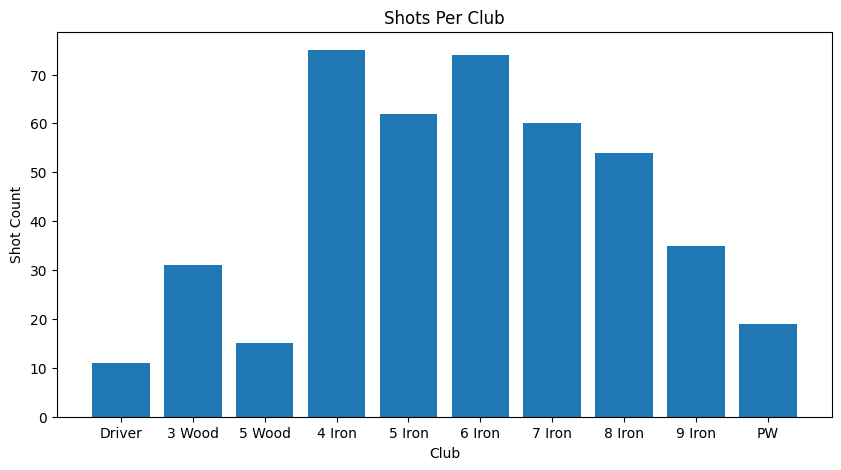

In [13]:
value_counts = df['Club Type'].value_counts()
value_counts = fixIndexes(value_counts)
plt.figure(figsize=(10, 5))
plt.bar(value_counts.index, value_counts)
plt.ylabel('Shot Count')
plt.xlabel('Club')
plt.title('Shots Per Club')

plt.show()

Looking for outliers: below I have plotted ball speed vs. carry distance to look for any outliers in the data. As you can see, there is a single point that has a ball speed of 9.8 mph and is clearly an anomaly. (I accidentally tapped the ball and the radar picked it up.)

This single point will be removed.

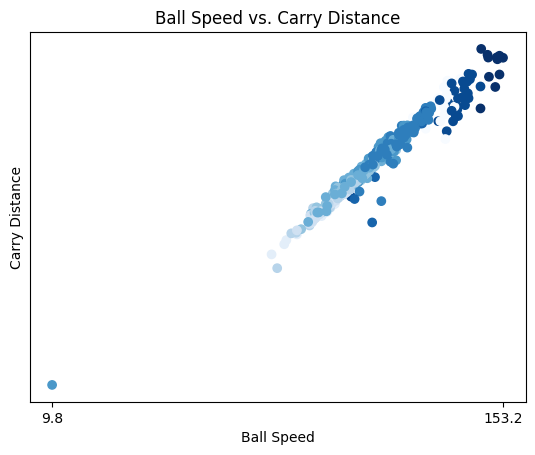

In [14]:
xpoints = df['Ball Speed']
ypoints = df['Carry Distance']

plt.scatter(xpoints, ypoints, c=df['Club Color'], cmap='Blues', label='Club Type')

max_speed = df['Ball Speed'].max()
min_speed = df['Ball Speed'].min()
max_dist = df['Carry Distance'].max()

plt.xticks([max_speed, min_speed])
plt.yticks([])
plt.xlabel('Ball Speed')
plt.ylabel('Carry Distance')
plt.title('Ball Speed vs. Carry Distance')
plt.show()

Removing the outlier

In [15]:
min_index = df['Carry Distance'].idxmin()
df = df.drop(min_index)

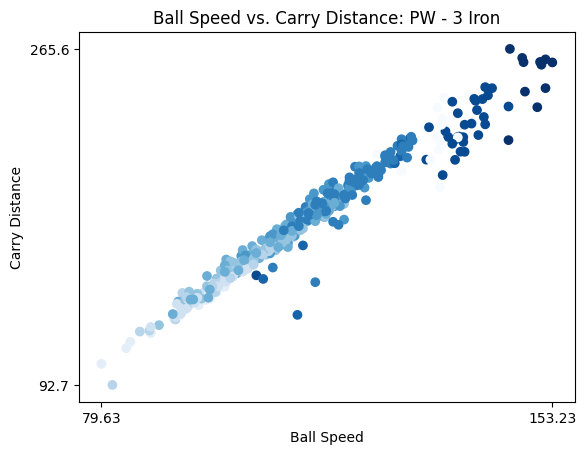

In [16]:
max_speed = df['Ball Speed'].max()
min_speed = df['Ball Speed'].min()
max_dist = df['Carry Distance'].max()
min_dist = df['Carry Distance'].min()

xpoints = df['Ball Speed']
ypoints = df['Carry Distance']

plt.scatter(xpoints, ypoints, c=df['Club Color'], cmap='Blues', label='Club Type')

plt.xticks([max_speed, min_speed])
plt.yticks([min_dist, max_dist])
plt.xlabel('Ball Speed')
plt.ylabel('Carry Distance')
plt.title('Ball Speed vs. Carry Distance: PW - 3 Iron')
plt.show()

This looks much better, now I will remove some more outliers that are a result of a broken 3 iron.

In [17]:
#remove the 3 3-iron outliers
df = df[df['Club Type'] != '3 Iron']

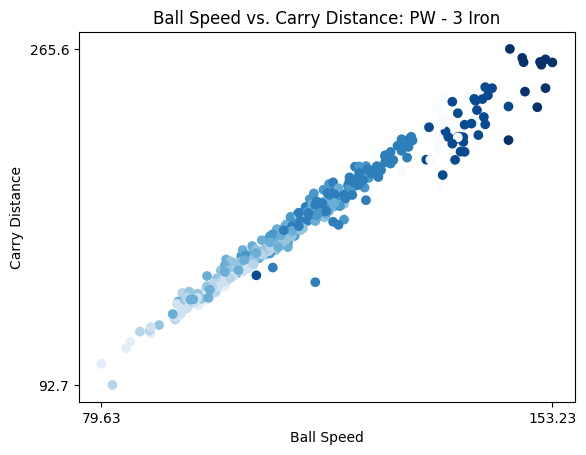

In [18]:
# looking at the same plot to verify the outliers have been removed
max_speed = df['Ball Speed'].max()
min_speed = df['Ball Speed'].min()
max_dist = df['Carry Distance'].max()
min_dist = df['Carry Distance'].min()

xpoints = df['Ball Speed']
ypoints = df['Carry Distance']

plt.scatter(xpoints, ypoints, c=df['Club Color'], cmap='Blues', label='Club Type')

plt.xticks([max_speed, min_speed])
plt.yticks([min_dist, max_dist])
plt.xlabel('Ball Speed')
plt.ylabel('Carry Distance')
plt.title('Ball Speed vs. Carry Distance: PW - 3 Iron')
plt.show()

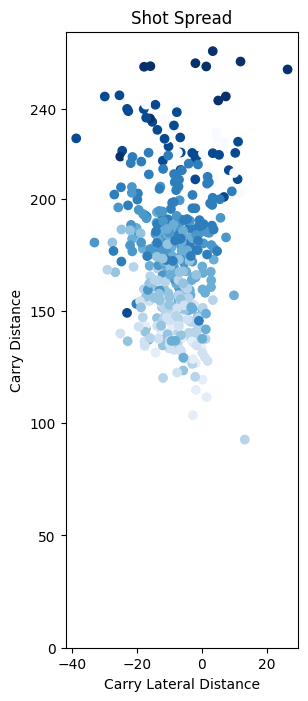

In [19]:
ypoints = df['Carry Distance']
xpoints = df['Carry Lateral Distance']


plt.figure(figsize=(3, 8))
plt.scatter(xpoints, ypoints, c=df['Club Color'], cmap='Blues', label='Club Type')

#plt.xticks([max_speed, min_speed])
plt.yticks([0, 50, 100, 150,200,240])
plt.ylabel('Carry Distance')
plt.xlabel('Carry Lateral Distance')
plt.title('Shot Spread')
mplc.cursor(hover=True)
plt.show()

Looking at a 3 dimensional plot that shows lateral carry, carry, and peak height, we can see that there are a couple of outliers that have a peak height below 20 ft. These are most likely "shanks". I am going to remove these from the dataset as I don't want these to skew the data.

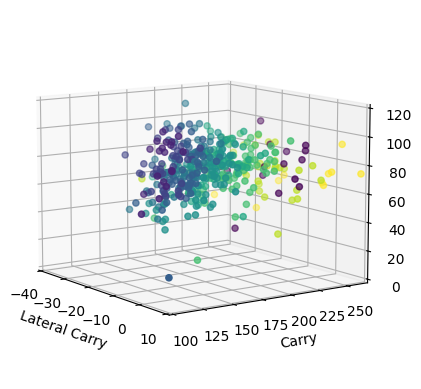

In [20]:
ax = plt.figure().add_subplot(projection='3d')
y=df['Carry Distance'].astype(int)
z=df['Peak Height'].astype(int)
x=df['Carry Lateral Distance'].astype(int)
  
ax.view_init(-170,  35) 

ax.scatter(x, y, z, c=df['Club Color'], marker='o')

# Make legend, set axes limits and labels
ax.set_xlim(10, -40)
ax.set_ylim(100, 265)
ax.set_zlim(120, 0)
ax.set_xlabel('Lateral Carry')
ax.set_ylabel('Carry')
ax.set_zlabel('Peak Height')


plt.show()

In [21]:
mean_by_club = round(df.groupby('Club Type')['Carry Distance'].mean(), 2)
min_by_club = round(df.groupby('Club Type')['Carry Distance'].min(), 2)
max_by_club = round(df.groupby('Club Type')['Carry Distance'].max(), 2)

mean_by_club = fixIndexes(mean_by_club)
max_by_club = fixIndexes(max_by_club)
min_by_club = fixIndexes(min_by_club)




In [22]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center', bbox = dict(facecolor = 'skyblue', alpha =.7, mouseover=True))

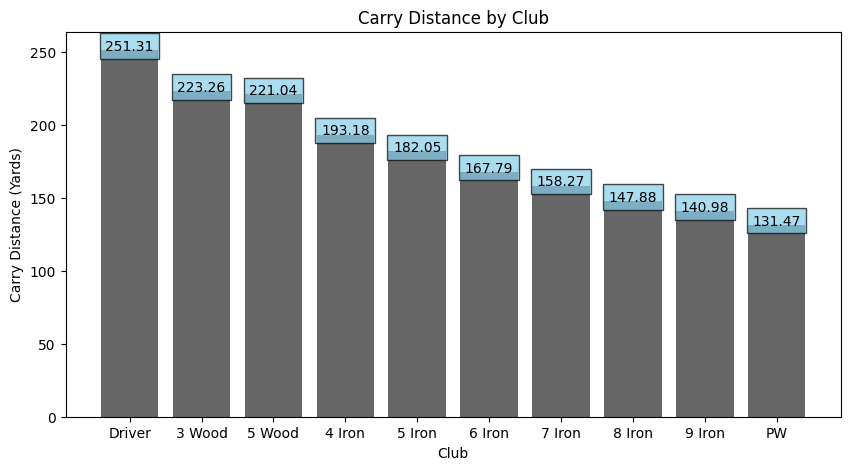

In [23]:
colors = plt.cm.Accent(df['Club Color'])
plt.figure(figsize=(10, 5))
plt.bar(mean_by_club.index, mean_by_club.values, color=colors)
addlabels(mean_by_club.index, mean_by_club.values)
plt.ylabel('Carry Distance (Yards)')
plt.xlabel('Club')
plt.title('Carry Distance by Club')
mplc.cursor(hover=True)
plt.show()


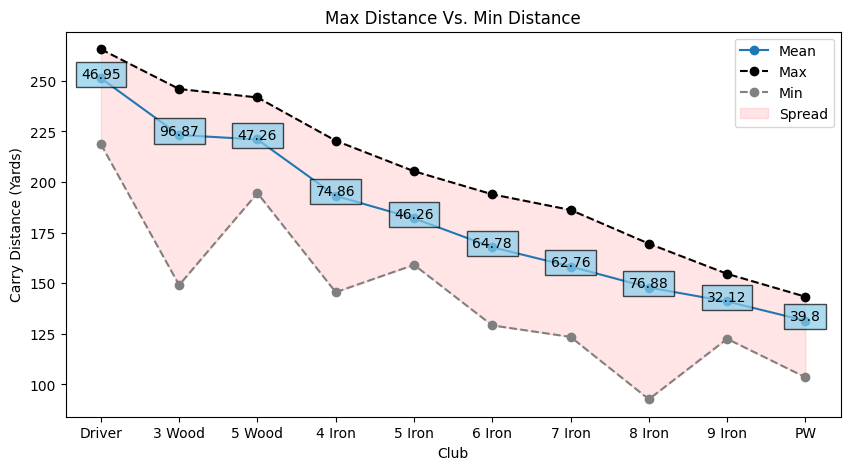

In [24]:
def addlabelMidpoint(x,y):
    for i in range(len(x)):
        plt.text(i, mean_by_club.values[i], round(y[i],2), ha = 'center', bbox = dict(facecolor = 'skyblue', alpha =.7, mouseover=True))

# Calculate distance and midpoint (example at x=3)
diff = max_by_club.values - min_by_club.values
midpoint = (max_by_club.values - min_by_club.values)/2
plt.figure(figsize=(10, 5))
addlabelMidpoint(mean_by_club.index, diff)

plt.plot(mean_by_club.index, mean_by_club.values, marker='o')
plt.plot(max_by_club.index, max_by_club.values, color='black', linestyle='--', marker='o')
plt.plot(min_by_club.index, min_by_club.values, color='grey', linestyle='--', marker='o')
plt.fill_between(mean_by_club.index, max_by_club.values, min_by_club.values, alpha=0.1, color='red')

plt.title('Max Distance Vs. Min Distance')
plt.legend(['Mean', 'Max', 'Min', 'Spread'])
plt.xlabel('Club')
plt.ylabel('Carry Distance (Yards)')
plt.show()

In [25]:
q1 = round(df.groupby('Club Type')['Carry Distance'].quantile(0.25), 2)
q2 = round(df.groupby('Club Type')['Carry Distance'].quantile(0.5), 2)
q3 = round(df.groupby('Club Type')['Carry Distance'].quantile(0.75), 2)
q1 = fixIndexes(q1)
q2 = fixIndexes(q2)
q3 = fixIndexes(q3)


/var/folders/3h/h97fc_615jxbc5q34dt7lkk00000gn/T/ipykernel_89922/3578635194.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(q1.index, fontsize = 7)
/var/folders/3h/h97fc_615jxbc5q34dt7lkk00000gn/T/ipykernel_89922/3578635194.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(q2.index, fontsize = 7)


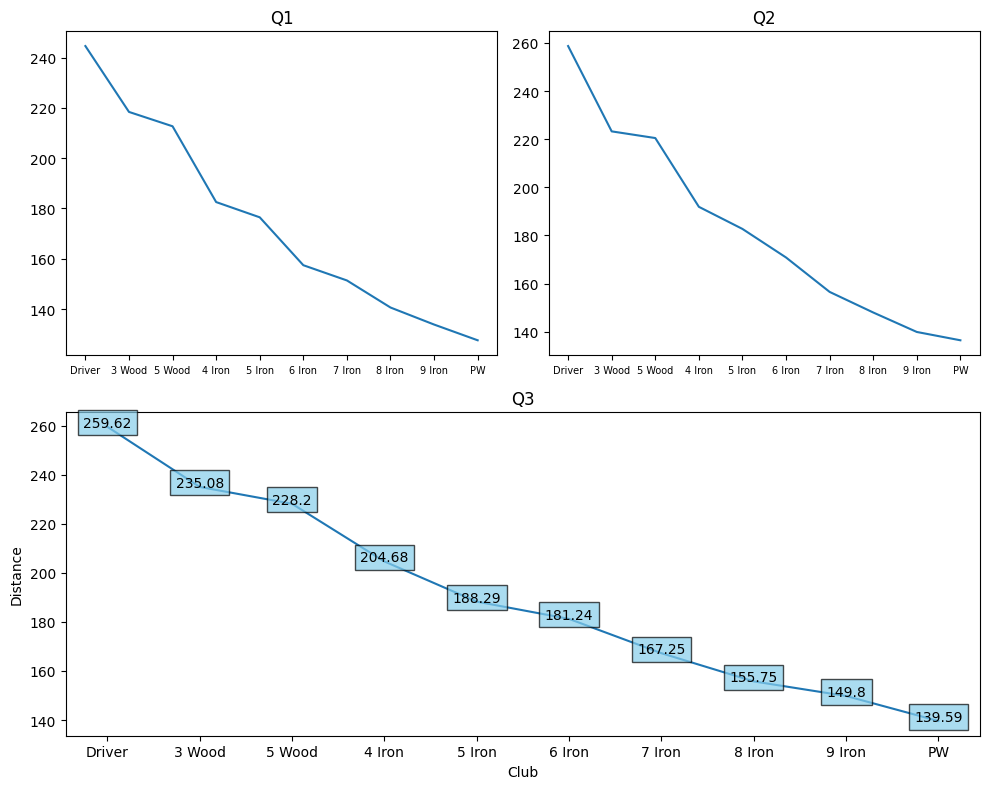

In [26]:
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

ax1.plot(q1.index, q1.values)
ax1.set_title('Q1')
ax1.set_xticklabels(q1.index, fontsize = 7)

ax2.plot(q2.index, q2.values)
ax2.set_title('Q2')
ax2.set_xticklabels(q2.index, fontsize = 7)

ax3.plot(q3.index, q3.values)
ax3.set_title('Q3')
ax3.set_ylabel('Distance')
ax3.set_xlabel('Club')
addlabels(q3.index, q3.values)

plt.tight_layout()
plt.show()

## Web Scraping

Just for fun, I want to pull in some data that shows the average carry distances for profesional golfers on the PGA Tour. I will then compare my distances to the pros (spoiler alert, it won't be close.)

In [27]:
r = requests.get('https://www.golfmonthly.com/tour/how-far-pga-tour-players-hit-every-club-in-the-bag')

# check status code for response received
# success code - 200
print(r)

soup = BeautifulSoup(r.content, 'html.parser')

print('Classes of each table:')
for table in soup.find_all('table'):
    print(table.get('class'))

<Response [200]>
Classes of each table:
['table__wrapper', 'table__wrapper--inbodyContent', 'table__wrapper--sticky', 'table__wrapper--divider']


In [28]:
# Creating list with all tables
tables = soup.find_all('table')

#  Looking for the table with the correct class
table = soup.find('table', class_='table__wrapper table__wrapper--inbodyContent table__wrapper--sticky table__wrapper--divider')

In [29]:
pro_df = pd.DataFrame(columns=['Club', 'Club Speed', 'Ball Speed', 'Spin Rate', 'Carry'])

club = []
club_speed = []
ball_speed = []
spin = []
carry = []

for row in table.tbody.find_all('tr'):    
    # Find all data for each column
    columns = row.find_all('td')
    
    if(columns != []):
        club.append(columns[0].text.strip())
        club_speed.append(columns[1].text.strip())
        ball_speed.append(columns[2].text.strip())
        spin.append(columns[3].text.strip())
        carry.append(columns[4].text.strip())

print(club)
pro_df['Club'] = club
pro_df['Club Speed'] = club_speed
pro_df['Ball Speed'] = ball_speed
pro_df['Spin Rate'] = spin
pro_df['Carry'] = carry

pro_df

['Driver', '3-Wood', '5-Wood', 'Hybrid', '3-Iron', '4-Iron', '5-Iron', '6-Iron', '7-Iron', '8-Iron', '9-Iron', 'Pitching Wedge']


,Club,Club Speed,Ball Speed,Spin Rate,Carry
0,Driver,115,171,2545,282
1,3-Wood,110,162,3663,249
2,5-Wood,106,156,4322,236
3,Hybrid,102,149,4587,231
4,3-Iron,100,145,4404,218
5,4-Iron,98,140,4782,209
6,5-Iron,96,135,5280,199
7,6-Iron,94,130,6204,188
8,7-Iron,92,123,7124,176
9,8-Iron,89,118,8078,164


In [30]:
# converting values to floats
pro_df['Club Speed'] = pd.to_numeric(pro_df['Club Speed'])
pro_df['Ball Speed'] = pd.to_numeric(pro_df['Ball Speed'])
pro_df['Spin Rate'] = pd.to_numeric(pro_df['Spin Rate'])
pro_df['Carry'] = pd.to_numeric(pro_df['Carry'])

# renaming club values to match my data
pro_df.replace('4-Iron', '4 Iron', inplace=True)
pro_df.replace('5-Iron', '5 Iron', inplace=True)
pro_df.replace('6-Iron', '6 Iron', inplace=True)
pro_df.replace('7-Iron', '7 Iron', inplace=True)
pro_df.replace('8-Iron', '8 Iron', inplace=True)
pro_df.replace('9-Iron', '9 Iron', inplace=True)
pro_df.replace('3-Wood', '3 Wood', inplace=True)
pro_df.replace('5-Wood', '5 Wood', inplace=True)
pro_df.replace('Pitching Wedge', 'PW', inplace=True)

# dropping the club types that I do not have my own data for
pro_df.drop(index=[3, 4], inplace=True)
pro_df = pro_df.reset_index(drop=True)

pro_df


,Club,Club Speed,Ball Speed,Spin Rate,Carry
0,Driver,115,171,2545,282
1,3 Wood,110,162,3663,249
2,5 Wood,106,156,4322,236
3,4 Iron,98,140,4782,209
4,5 Iron,96,135,5280,199
5,6 Iron,94,130,6204,188
6,7 Iron,92,123,7124,176
7,8 Iron,89,118,8078,164
8,9 Iron,87,112,8793,152
9,PW,84,104,9316,142


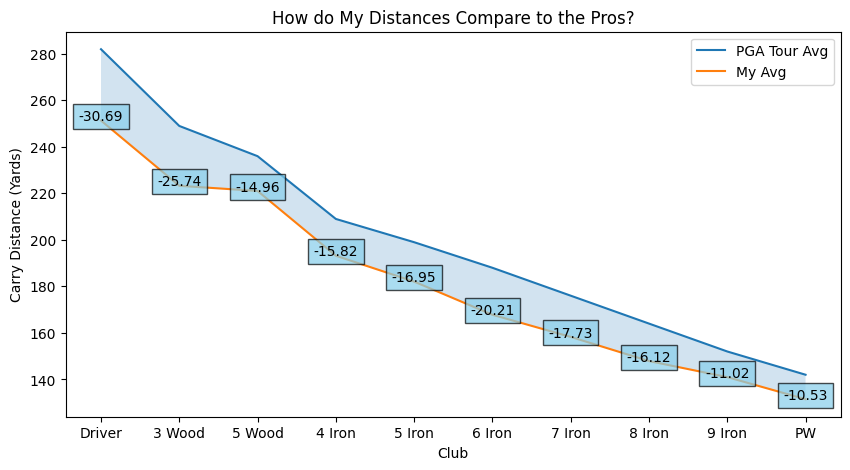

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(pro_df['Club'], pro_df['Carry'])
plt.plot(mean_by_club.index, mean_by_club.values)
plt.fill_between(mean_by_club.index, mean_by_club.values, pro_df['Carry'], alpha=0.2, label='Area between curves')
plt.title('How do My Distances Compare to the Pros?')
plt.legend(['PGA Tour Avg', 'My Avg'])
plt.xlabel('Club')
plt.ylabel('Carry Distance (Yards)')
diff = pro_df['Carry'] - mean_by_club.values

addlabelMidpoint(mean_by_club.index, -diff)

plt.show()

## Enough About Distance!


There is another training section in the Awesome golf app that lets you choose from a variety of targets at a variety of distances. The appkeeps track of how many shots you take at each target as well as how many times you hit the green and how many times the ball finishes within 10 feet of the hole. Unfortunately, you cannot export this data, so I will be entering it manually. Thankfully, there is not a lot to enter. Below is a screenshot of the data collected I have collected in this target practice training.

<img src="approach_data.jpeg" alt="drawing" width="200"/>

In [48]:
approach_data = {
    "shots": [50, 271,287,136],
    "greens hit": [32, 141, 188, 53],
    "inside 10": [14, 20,11,4],
    "Distance": ["0-99", "100-149", "150-199", "200+"]
}

approach_df = pd.DataFrame(approach_data)

approach_df.head()


,shots,greens hit,inside 10,Distance
0,50,32,14,0-99
1,271,141,20,100-149
2,287,188,11,150-199
3,136,53,4,200+


In [49]:
approach_df['green hit prob'] = round(approach_df['greens hit'] / approach_df['shots'], 2)
approach_df['inside 10 prob'] = round(approach_df['inside 10'] / approach_df['shots'], 2)

approach_df.head()

,shots,greens hit,inside 10,Distance,green hit prob,inside 10 prob
0,50,32,14,0-99,0.64,0.28
1,271,141,20,100-149,0.52,0.07
2,287,188,11,150-199,0.66,0.04
3,136,53,4,200+,0.39,0.03


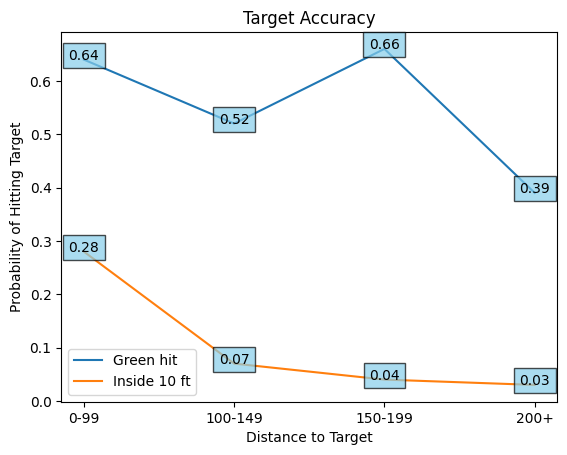

In [50]:
plt.plot(approach_df['Distance'], approach_df['green hit prob'])
plt.plot(approach_df['Distance'], approach_df['inside 10 prob'])
plt.xlabel('Distance to Target')
plt.ylabel('Probability of Hitting Target')
plt.title('Target Accuracy')
addlabels(approach_df['Distance'], approach_df['green hit prob'])
addlabels(approach_df['Distance'], approach_df['inside 10 prob'])
plt.legend(["Green hit", "Inside 10 ft"], loc="lower left")
plt.show()

Exporting the final dataframes to new csv files to create a dashboard with Tableau.

In [51]:
pro_df.to_csv('shot_csvs/output/pro_stats.csv')
approach_df.to_csv('shot_csvs/output/approach_stats.csv')
df.to_csv('shot_csvs/output/combined_and_cleaned.csv')

Finally, I want to calculate the probability of making a hole in one from these various distances

In [52]:
def calculateHoleInOneProb(df):
    ten_ft_area = math.pi * (60**2)
    hole_area = math.pi * (2.125**2)
    hole_in_one_prob = hole_area / ten_ft_area

    #confirm required columns are in the dataframe
    cols = ['inside 10 prob', 'Distance']
    columns_exist = pd.Series(cols).isin(df.columns).all()
    if columns_exist:
        # if required columns exist, calculate p of hole in one for each distance
        p = []
        for idx, row in df.iterrows():
            p.append(hole_in_one_prob * df.loc[idx, 'inside 10 prob'])
        df['P of HIO'] = p
        # printing the results
        df_subset = df[['Distance', 'P of HIO']]
        df_combined = pd.concat([df_subset], axis=1)
        print(df_combined.to_string())
            
    else:
        #not all required columns exist, exit the function
        print("Not all specified columns are present.")

In [53]:
calculateHoleInOneProb(approach_df)

  Distance  P of HIO
0     0-99  0.000351
1  100-149  0.000088
2  150-199  0.000050
3     200+  0.000038


## Conclusion

The gaps in between my 4 iron to 5 iron and my 6 iron to 7 iron are quite large. This tells me that I need to work on htting the 5 and 7 irons further. I can also see that most of my clubs are 16-20 yards shorter than the average professional. I'm not too concerned with these numbers as the pros are training for hours everyday, it was really just for my own curiosity that I plotted those numbers. It does however show that there is a lot of room for improvement. I also learned that the distance between a good shot and bad shot for my 8 and 4 irons are the largest of all of my clubs. I need to work on my consistency with those 2 clubs in particular.

It is also clear that with my longer clubs, 4 Iron, 3 Wood and Driver, my shots have more of a tendency to go to the right (a slice.) I've been struggling with this (as most amateur golfers do) since I started golfing as a child. Although I already knew about and am working on this part of my game, it is reassuring that the radar device is showing this tendency as it is reflecting what I see in the real world. This gives some level of credibility to the data that is being collected.